# Sandbox Skript

## Generate Paths

In [1]:
from src.data.make_dataset import DataLoader
from esig import tosig
from BuehlerVAE.src.utils.leadlag import leadlag
import BuehlerVAE.src.logsig_inversion as logsig_inversion
import matplotlib.pyplot as plt
import numpy as np
# import torch

c:\Users\peter\OneDrive - TUM\Master TUM\Masterarbeit\MarketGenerators\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Specify the data loader parameters
n = 1000000
n_steps = 252
nPeriods = n_steps/252
gbm_params = {
    "S0": 1., 
    "mu": 0.05,
    "sigma": 0.2, 
    "T": nPeriods, 
    "n_points": n_steps+1, 
    "n": n
}

In [3]:
gbm_loader = DataLoader(method="GBM", params=gbm_params, seed=0)
pathsGBM, timesGBM = gbm_loader.create_dataset(output_type="np.ndarray")

In [4]:
# Select paths to analyze
paths = pathsGBM
times = timesGBM

In [5]:
# Alles nochmal checken!
import pandas as pd
paths_df = pd.DataFrame(paths.T)
test_log_returns_df = np.log(paths_df).diff(axis=1).iloc[:, 1:]
print("Input mean:\t", np.mean(paths_df.iloc[:, -1]))
print("Expected mean:\t", np.exp(0.05*nPeriods))
print("-------------------------------------")
print("Av. path stdev:\t", test_log_returns_df.std(axis=1).mean()*np.sqrt(n_steps/nPeriods))
print("Exp. stdev:\t", 0.2)

Input mean:	 1.0516283242205355
Expected mean:	 1.0512710963760241
-------------------------------------
Av. path stdev:	 0.19978937761511723
Exp. stdev:	 0.2


In [6]:
from scipy.stats import norm
K = 1
S0 = 1
r = 0.05
T = nPeriods
t = 0
sigma = 0.2
d1 = (np.log(S0/K) + (r + sigma**2/2)*(T-t)) / (sigma*np.sqrt(T-t))
d2 = d1 - sigma*np.sqrt(T-t)

theoretical_call_price = S0*norm.cdf(d1) - K*np.exp(-r*(T-t))*norm.cdf(d2)
theoretical_put_price = theoretical_call_price + K*np.exp(-r*(T-t)) - S0

europe_call = lambda x: np.maximum(x - K, 0)
europe_put = lambda x: np.maximum(K - x, 0)
monte_carlo_call_gen_price = np.mean(np.exp(-r*(T-t))*europe_call(paths_df.iloc[:, -1]))
monte_carlo_put_gen_price = np.mean(np.exp(-r*(T-t))*europe_put(paths_df.iloc[:, -1]))

print("Theoretical call price:\t\t\t", theoretical_call_price)
print("Monte Carlo generated call price:\t", monte_carlo_call_gen_price)
print("-------------------------------------")
print("Theoretical put price:\t\t\t", theoretical_put_price)
print("Monte Carlo generated put price:\t", monte_carlo_put_gen_price)


Theoretical call price:			 0.10450583572185568
Monte Carlo generated call price:	 0.10478355488446833
-------------------------------------
Theoretical put price:			 0.05573526022256958
Monte Carlo generated put price:	 0.05567317374823228


In [10]:
# import pandas as pd
# paths_df = pd.DataFrame(paths)
# paths_df.to_csv(f"csv_export/{n}_GBM_paths.csv", index=False)

## Signature and Signature inversion 

In [5]:
import signatory as sg
from src.features.data_transformer import Transformer
# convert paths to torch tensor for signatory library
paths_torch = Transformer().arrays_to_torch_tensor(times, paths)
# set the depth of the signature (or order) 
# if granularity equals depth, output will be of same format as input
# depth = int(nPeriods/dt)
depth = 20
signatures = sg.signature(paths_torch, depth)
# inverted_paths = sg.signature(signatures, depth, inverse=True)
inverted_paths = sg.invert_signature(signatures, depth=depth, channels=2, initial_position=paths_torch[:, 0, :])

times_recovered, paths_recovered = Transformer().torch_tensor_to_arrays(inverted_paths)

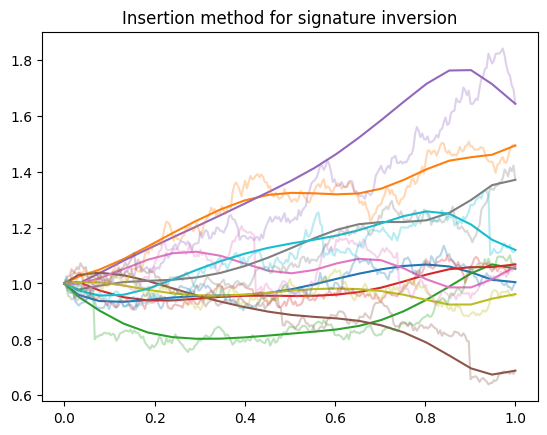

In [6]:
# paths are smoothened by the signature transformation
plt.plot(times_recovered, paths_recovered)
plt.gca().set_prop_cycle(None)
plt.plot(times, paths, alpha=0.3)
plt.title("Insertion method for signature inversion")
plt.show()

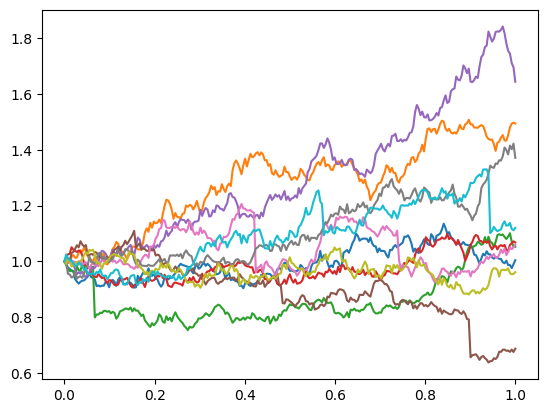

In [7]:
plt.plot(times, paths)
plt.show()

In [8]:
# Compute log-signature
path = paths[:,0]
order = 4
leadlag_path = leadlag(path)
logsig = tosig.stream2logsig(leadlag_path, order)
# normal log-sig:
print(sg.logsignature(paths_torch, order)[0,:].numpy())
# leadlag log-sig:
print(f"Leadlag Log-signature:\n {logsig}")

[ 1.00000000e+00  4.70621746e-03  1.00387834e-02 -1.20842347e-02
  1.61822279e-03  3.99645124e-05 -5.10168313e-05  4.13947060e-06]
Leadlag Log-signature:
 [ 4.70621746e-03  4.70621746e-03 -2.16777896e-02  5.16987766e-05
  1.91842816e-05 -3.35201630e-05 -6.60491765e-05 -3.36794684e-05]


In [ ]:
n_iterations = 100
n_organisms = 1000
recovered_path, loss = logsig_inversion.train(logsig, order, n_iterations, n_organisms, path.shape[0],
                                              0.01, 10)

In [ ]:
plt.plot(recovered_path)
# next: Check leadlag
plt.plot(path-1)
plt.show()
print(f"Real log-signature: {logsig}")
print(f"Recovered log-signature: {tosig.stream2logsig(leadlag(recovered_path), order)}")

In [10]:
path.shape

(253,)

In [25]:
import torch
import numpy as np
import signatory as sg

custom_path = torch.tensor([[[0.0], [0.1], [0.2], [10], [2], [-1], [0.3], [0.2], [0.1], [0.0]]])

# times_reshaped = times.reshape(-1, 1)
# paths_tensor_format = np.stack([np.tile(times_reshaped, (1, paths.shape[1])), paths], axis=2)
# paths_tensor_format = np.transpose(paths_tensor_format, axes=(1, 0, 2))
# paths_torch = torch.from_numpy(paths_tensor_format)
# paths_tensor_format.shape
# custom_path_reshaped = np.reshape(custom_path, (1, 10))
# custom_path_torch = torch.from_numpy(custom_path)
# custom_path_torch
sg.signature(custom_path, 4) 
# custom_path.shape

# torch.rand(10, 1).shape
# custom_path_torch.shape

tensor([[-5.9605e-08,  9.3132e-10, -5.0629e-06,  6.1008e-05]])

In [2]:
import BuehlerVAE.src.rough_bergomi as rb
import BuehlerVAE.src.utils.leadlag as ll
from esig import tosig
import numpy as np
import matplotlib.pyplot as plt
bergomi_paths = rb.rough_bergomi(   
    grid_points=20,
    M=5,
    H=0.14,
    T=20/252,
    rho=-0.85,
    xi0=0.1,
    nu=1.5,
    S0=1.
)
path1 = bergomi_paths[0]
[ll.leadlag(path) for path in bergomi_paths][0][:,0]
# # tosig.stream2sig expects at least 2 paths
# tosig.stream2sig(path1, 3).shape
test_path = np.array([
    [0.0, 1.0],
    [0.1, 1.1],
    [0.2, 1.2],
    [0.3, 1.3],
    [0.4, 1.4],
    [0.5, 1.5],
    [0.6, 1.6],
    [0.7, 1.7],
    [0.8, 1.8],
    [0.9, 1.9]
])
reversed_test_path = np.flip(test_path[:,1], axis=0)
concatenated_path = np.vstack((test_path, np.column_stack((np.arange(1.0, 2.0, 0.1), reversed_test_path))))
tosig.stream2sig(test_path, 3)
# plt.plot(concatenated_path)
# plt.show()

array([1.    , 0.9   , 0.9   , 0.405 , 0.405 , 0.405 , 0.405 , 0.1215,
       0.1215, 0.1215, 0.1215, 0.1215, 0.1215, 0.1215, 0.1215])

In [96]:
import signatory as sg
import torch
import BuehlerVAE.src.utils.leadlag as ll

test_path_np = np.array([[
    [0.0, 1.0],
    [0.1, 1.1],
    [0.2, 1.2],
    [0.3, 1.3],
    [0.4, 1.4],
    [0.5, 1.5],
    [0.6, 1.6],
    [0.7, 1.7],
    [0.8, 1.8],
    [0.9, 1.0]
]])
test_path_torch = torch.from_numpy(test_path_np)
# only second entry for lead lag transformation
test_path_lead_lag = torch.from_numpy(
    ll.leadlag(test_path_np[0,:,1])).reshape(1, test_path_np.shape[1]*2-1, 2
) 
test_path1dim = test_path_torch[:,:,1].reshape(1, 10, 1)

# initial path without time dimensions
print(sg.signature(test_path1dim, 3, scalar_term=True))
# lag (0) or lead (1) transformed path (without time dimensions)
# ==> Same signature because of time invariance
print(sg.signature(test_path_lead_lag[:,:,0].reshape(1,19,1), 3, scalar_term=True))
# lead lag transformed path
print(sg.signature(test_path_lead_lag, 3, scalar_term=True))
print(sg.signature(test_path_torch, 3, scalar_term=True))


tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00, -1.3878e-17]],
       dtype=torch.float64)
tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00, -1.3878e-17]],
       dtype=torch.float64)
tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -3.6000e-01,
          3.6000e-01,  0.0000e+00, -1.3878e-17, -1.8600e-01,  3.7200e-01,
          1.0200e-01, -1.8600e-01, -2.0400e-01,  1.0200e-01, -1.3878e-17]],
       dtype=torch.float64)
tensor([[ 1.0000e+00,  9.0000e-01,  0.0000e+00,  4.0500e-01, -3.6000e-01,
          3.6000e-01,  0.0000e+00,  1.2150e-01, -2.0400e-01,  8.4000e-02,
          9.6000e-02,  1.2000e-01, -1.9200e-01,  9.6000e-02, -1.3878e-17]],
       dtype=torch.float64)


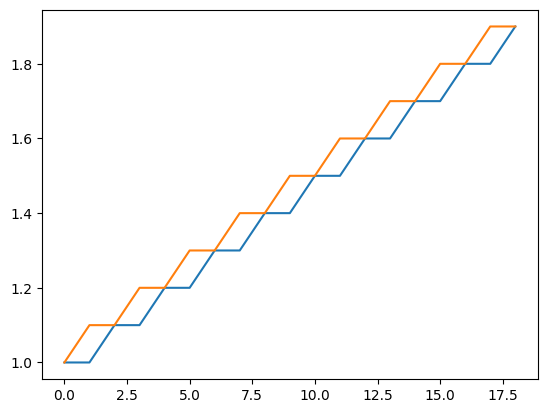

(1, 10, 2)

In [92]:
import matplotlib.pyplot as plt 
# test_path_lead_lag[0,:,0].numpy()
plt.plot(test_path_lead_lag[0,:,0].numpy())
plt.plot(test_path_lead_lag[0,:,1].numpy())
plt.show()